# [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PHYS486-S22/PHYS486-S22/blob/main/SampleNotebooks/PendulumAsLogisticMap.ipynb)

## Imports & Preferences

In [1]:
#import packages that we'll use often.
import numpy as np
#import scipy as sp
#from scipy.interpolate import interp1d

import math

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.colorbar as cb
%matplotlib inline

from IPython.display import set_matplotlib_formats
plt.rcParams['savefig.dpi'] = 200

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

# Functions to Model a Damped, Driven Pendulum

In [2]:
#calculate dthetha/dt and domega/dt at a given point in time (ie, no stepping forward)
def PendulumDerivatives(theta, omega, time, g, l, q, driveForce, driveFrequency):
    dtheta = omega
    #note that this equation works only with a negative g value (ie, -9.8 vs. 9.8 as in caption
    #of Figure 3.6.  ALSO NOTE SIGN CHANGE IN ERRATA!)
    domega = (g/l)*np.sin(theta) - q*omega + driveForce*np.sin(driveFrequency*time)
    return dtheta, domega

In [3]:
#take in the physical parameters of a damped driven pendulum and advance omega by a timeStep
#allow an optional parameter to remap theta to between +/- pi.
def AdvancePendulum(theta, omega, dtheta, domega, timeStep, remap = False):
    next_theta = theta + dtheta*timeStep
    if (remap == True):
        if (next_theta > math.pi):
            next_theta = next_theta - 2*math.pi
        if (next_theta < -1 * math.pi):
            next_theta = next_theta + 2*math.pi
    next_omega = omega + domega*timeStep
    return next_theta, next_omega

In [4]:
#make a compact way to set the parameters that will control our pendulum
def definePendulum(theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, timeStep, FullTime):
    return theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, timeStep, FullTime

In [5]:
#advance the Pendulum by a full RK2 timestep (which requires calculating derivatives at half timesteps)
def PendulumRK2Step(theta_i, omega_i, time_i, g, l, q, driveForce, driveFrequency, RK2timeStep, remap = False):
    
    #calculate half a time step. 
    half_step = RK2timeStep*0.5
    
    #calculate the derivatives here
    dtheta_now, domega_now = PendulumDerivatives(theta_i, omega_i, time_i, g, l, q, driveForce, driveFrequency)
    
    #advance the variables half a step
    if (remap == True):
        theta_half, omega_half = AdvancePendulum(theta_i, omega_i, dtheta_now, domega_now, half_step, remap = True)
    else:
        theta_half, omega_half = AdvancePendulum(theta_i, omega_i, dtheta_now, domega_now, half_step)        
    
    #recalculate the derivatives
    dtheta_half, domega_half = PendulumDerivatives(theta_half, omega_half, time_i + half_step, g, l, q, driveForce, driveFrequency)

    #use the new derivatives to advance the variables a full step
    if (remap == True):
        theta_full, omega_full = AdvancePendulum(theta_i, omega_i, dtheta_half, domega_half, RK2timeStep, remap = True)
    else:
        theta_full, omega_full = AdvancePendulum(theta_i, omega_i, dtheta_half, domega_half, RK2timeStep)

    #print(theta_full, omega_full, time_i + RK2timeStep)    
        
    return theta_full, omega_full, time_i + RK2timeStep

In [6]:
#make the Pendulum run for a certain timeperiod, with a certain timestep
def RunPendulum(theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime, remap = False):
    
    #determine how many timesteps we need to run over:
    timeSteps = int(FullTime//RK2timeStep)
    
    thetas = [theta_0]
    omegas = [omega_0]
    times = [time_0]
    
    #loop through that many steps
    for i in range(0,timeSteps-1):
        
        if (remap == True):
            newTheta, newOmega, newTime = PendulumRK2Step(thetas[i], omegas[i], times[i], g, l, q, driveForce, driveFrequency, RK2timeStep, remap = True)
        else:
            newTheta, newOmega, newTime = PendulumRK2Step(thetas[i], omegas[i], times[i], g, l, q, driveForce, driveFrequency, RK2timeStep)
            
        thetas = np.append(thetas, newTheta)
        omegas = np.append(omegas, newOmega)
        times = np.append(times, newTime)
    
    return thetas, omegas, times

# Functions to visualize the motion of the Pendulum

In [7]:
#make a wrapper for the Pendulum routine that enables us to make Poincare sections
def MakePoincare(theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime, skipPeriods, remap = False):

    #go ahead and run the pendulum
    if (remap == True):
        thetas, omegas, times = RunPendulum(theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime, remap = True)
    else:
        thetas, omegas, times = RunPendulum(theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime, remap = False)

    #and now create an array of timestamps spaced by one period. 
    one_period = 2*math.pi / driveFrequency
    n_Periods = int(math.floor(FullTime / one_period))
    #make sure to discard the first skipPeriods periods, to give the system time to move beyond its initial transient behavior
    JustPeriods = one_period*np.linspace(skipPeriods,n_Periods-1,n_Periods-(skipPeriods))
        
    #print('made it here')
    #print(JustPeriods)
        
    interp_thetas = np.interp(JustPeriods, times, thetas)    
    interp_omegas = np.interp(JustPeriods, times, omegas)    

    return interp_thetas, interp_omegas

In [8]:
def MakeBifurcation(driveForceStart, driveForceEnd, driveForceResolution):

    #except for the driveForce, use the same starting parameters for all pendulums
    n_driveForces = int(math.ceil( (driveForceEnd - driveForceStart) / driveForceResolution))
    driveForces = np.linspace(driveForceStart, driveForceEnd, n_driveForces)
    
    all_DriveForces = []
    all_thetas = []
    
    #loop through all our driveForces
    for i in range(0,n_driveForces-1):
        print(i, n_driveForces-1)
        #define the samependulum for each set-up
        theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime = definePendulum(0.2, 0, 0, -9.8, 9.8, 0.5, 0, 2/3, 0.02, 1200)
        skipPeriods = 50
        these_thetas, these_omegas = MakePoincare(theta_0, omega_0, time_0, g, l, q, driveForces[i], driveFrequency, RK2timeStep, FullTime, skipPeriods, remap = True)
        all_thetas = np.append(all_thetas, these_thetas)
        all_DriveForces = np.append(all_DriveForces, driveForces[i]*np.ones(np.size(these_thetas)))
        
    BifurcationDiagram, = plt.plot(all_DriveForces, all_thetas, marker = '.', markersize = 5, color = 'r', linestyle = 'None')
    xlabel = plt.xlabel(r'F$_D$') 
    ylabel = plt.ylabel(r'$ \theta$ (radians)')
    ylim = plt.ylim(1,3)
    plt.savefig('BifurcationDiagram.png', format = 'png', bbox_inches='tight')

# Commands to actually run some pendulums and visualize the motion 

#### Run several pendulums to illustrate how the motion changes with different drive forces and frequencies

In [13]:
#try to replicate some figures

#first, run a pendulum with F_D = 0
#initialize the pendulum as in Figure 3.6
theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime = definePendulum(0.2, 0, 0, -9.8, 9.8, 0.5, 0, 2/3, 0.04, 60)

#now run to replicate pendulum at top of left panel of Figure 3.6
thetas_noDrive, omegas_noDrive, times_noDrive = RunPendulum(theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime)

#now run a pendulum with F_D = 0.5
#now run to replicate pendulum at bottom of left panel of Figure 3.6
theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime = definePendulum(0.2, 0, 0, -9.8, 9.8, 0.5, 0.5, 2/3, 0.04, 60)
thetas_ohFiveDrive, omegas_ohFiveDrive, times_ohFiveDrive = RunPendulum(theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime)

#Now run a pendulum with F_D = 1.2 (and run versions with & without remapping in 2pi domain)
#now run to replicate pendulum at bottom of left panel of Figure 3.6
theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime = definePendulum(0.2, 0, 0, -9.8, 9.8, 0.5, 1.2, 2/3, 0.04, 60)
thetas_oneTwoDrive_remap, omegas_oneTwoDrive_remap, times_oneTwoDrive_remap = RunPendulum(theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime, remap = True)
thetas_oneTwoDrive_NoRemap, omegas_oneTwoDrive_NoRemap, times_oneTwoDrive_NoRemap = RunPendulum(theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime)

#print some outputs for students to compare to
#newSelected = Table()
#newSelected.add_column(Column(data = times_oneTwoDrive_NoRemap, name='times (seconds)'))
#newSelected.add_column(Column(data = thetas_oneTwoDrive_NoRemap, name='thetas (no remap)'))
#newSelected.add_column(Column(data = omegas_oneTwoDrive_NoRemap, name='omegas (no remap)'))
#ascii.write(newSelected, 'verify_Pendulum_HW3.txt')

### Visualize the motion of the pendulums as a function of drive force

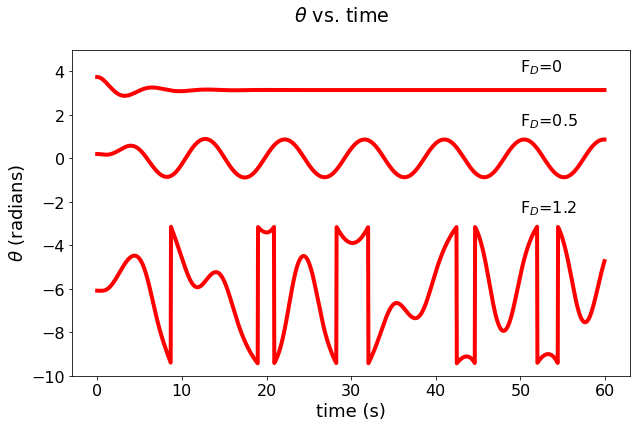

In [15]:
#plot the different pendula
leftTopThreeSix, = plt.plot(times_noDrive, 3*thetas_noDrive+math.pi, linewidth = 4, color = 'r', label = 'F$_D$=0')
leftmiddleThreeSix, = plt.plot(times_ohFiveDrive, thetas_ohFiveDrive, linewidth = 4, color = 'r', label = 'F$_D$=0')
leftBottomThreeSix, = plt.plot(times_oneTwoDrive_remap, thetas_oneTwoDrive_remap-2*math.pi, linewidth = 4, color = 'r', label = 'F$_D$=0')

#make plot look nice.
xlabel = plt.xlabel('time (s)') 
ylabel = plt.ylabel(r'$ \theta$ (radians)')
ylim = plt.ylim(-10, 5)
title = plt.suptitle(r'$\theta$ vs. time')
toplabel = plt.annotate(r'F$_D$=0', xy = (50,4), xytext = (50,4))
middlelabel = plt.annotate(r'F$_D$=0.5', xy = (50,1.5), xytext = (50,1.5))
bottomlabel = plt.annotate(r'F$_D$=1.2', xy = (50,-2.5), xytext = (50,-2.5))
ytick_loc, ytick_labels = plt.yticks()
plt.savefig('LeftThreeSix_notugly.png', bbox_inches='tight')

### Now show what remapping does, and use non-remapped simulation to demonstrate sensitivity to initial conditions by running models that are identical except for nudges to $\theta$

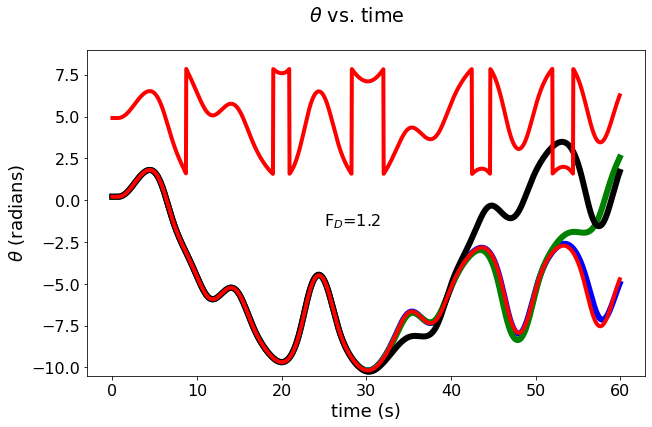

In [11]:
#create a set of initial thetas with offsets that increase by 1 order of magnitude per jump.
theta_smallest = theta_0+0.0001
theta_smaller = theta_0+0.001
theta_small = theta_0+0.01

#run the pendulums for each set of initial positions
thetas_oneTwoDrive_Est, omegas_oneTwoDrive_Est, times_oneTwoDrive_Est = RunPendulum(theta_smallest, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime)
thetas_oneTwoDrive_Er, omegas_oneTwoDrive_Er, times_oneTwoDrive_Er = RunPendulum(theta_smaller, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime)
thetas_oneTwoDrive_Small, omegas_oneTwoDrive_Small, times_oneTwoDrive_Small = RunPendulum(theta_small, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime)

#visualize the set of non-remapped pendula with different initial conditions
MiddleUnderThreeSix_Est, = plt.plot(times_oneTwoDrive_Est, thetas_oneTwoDrive_Est, linewidth = 6, color = 'b', label = 'F$_D$=0')
MiddleUnderThreeSix_Er, = plt.plot(times_oneTwoDrive_Er, thetas_oneTwoDrive_Er, linewidth = 6, color = 'g', label = 'F$_D$=0')
MiddleUnderThreeSix_Small, = plt.plot(times_oneTwoDrive_Small, thetas_oneTwoDrive_Small, linewidth = 6, color = 'black', label = 'F$_D$=0')
leftBottomThreeSix, = plt.plot(times_oneTwoDrive_remap, thetas_oneTwoDrive_remap+1.5*math.pi, linewidth = 4, color = 'r', label = 'F$_D$=0')

#and add the remapped version at the top for good measure.
MiddleBottomThreeSix, = plt.plot(times_oneTwoDrive_NoRemap, thetas_oneTwoDrive_NoRemap, linewidth = 4, color = 'r', label = 'F$_D$=0')

#make plot look nice.
ylabel = plt.ylabel(r'$ \theta$ (radians)')
xlabel = plt.xlabel('time (s)') 
ylabel = plt.ylabel(r'$ \theta$ (radians)')
title = plt.suptitle(r'$\theta$ vs. time')
bottomlabel = plt.annotate(r'F$_D$=1.2', xy = (25,-1.5), xytext = (25,-1.5))
ytick_loc, ytick_labels = plt.yticks()
ylim = plt.ylim(-10.5, 9)
plt.savefig('MiddleThreeSix.jpg', bbox_inches='tight')

### and check what $\omega$ looks like for the three F$_D$ values

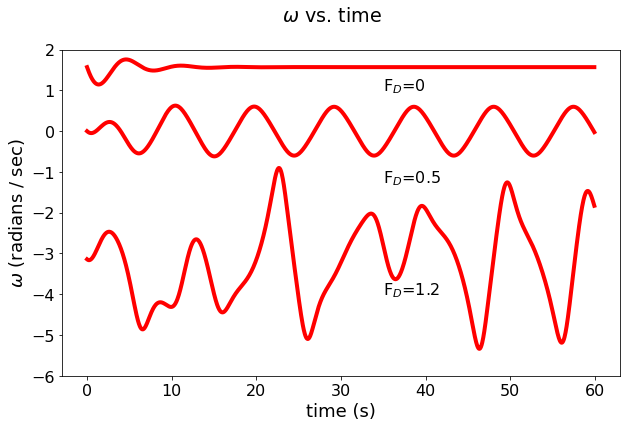

In [16]:
leftTopThreeSix, = plt.plot(times_noDrive, 3*omegas_noDrive+0.5*math.pi, linewidth = 4, color = 'r', label = 'F$_D$=0')
leftmiddleThreeSix, = plt.plot(times_ohFiveDrive, omegas_ohFiveDrive, linewidth = 4, color = 'r', label = 'F$_D$=0')
leftBottomThreeSix, = plt.plot(times_oneTwoDrive_remap, omegas_oneTwoDrive_remap-math.pi, linewidth = 4, color = 'r', label = 'F$_D$=0')

#make plot look nice.
xlabel = plt.xlabel('time (s)') 
ylabel = plt.ylabel(r'$ \omega$ (radians / sec)')
ylim = plt.ylim(-6, 2)
title = plt.suptitle(r'$\omega$ vs. time')
toplabel = plt.annotate(r'F$_D$=0', xy = (35,1), xytext = (35,1))
middlelabel = plt.annotate(r'F$_D$=0.5', xy = (35,-1.25), xytext = (35,-1.25))
bottomlabel = plt.annotate(r'F$_D$=1.2', xy = (35,-4), xytext = (35,-4))
ytick_loc, ytick_labels = plt.yticks()
plt.savefig('RightThreeSix.jpg', bbox_inches='tight')

## Now make Poincare diagrams to visualize motion in Phase space

### start with the nice, periodic F$_D$ = 0.5 case

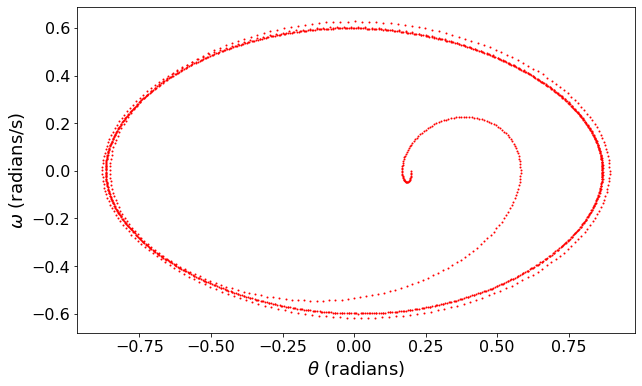

In [18]:
LeftThreeEight, = plt.plot(thetas_ohFiveDrive, omegas_ohFiveDrive, marker = '.', markersize = 2, color = 'r', linestyle = 'None')
ylabel = plt.ylabel(r'$\omega$ (radians/s)') 
xlabel = plt.xlabel(r'$ \theta$ (radians)')
plt.savefig('LeftThreeEight.jpg', bbox_inches='tight')

### now try F$_D$ = 1.2, with no remapping to emphasize chaotic behavior

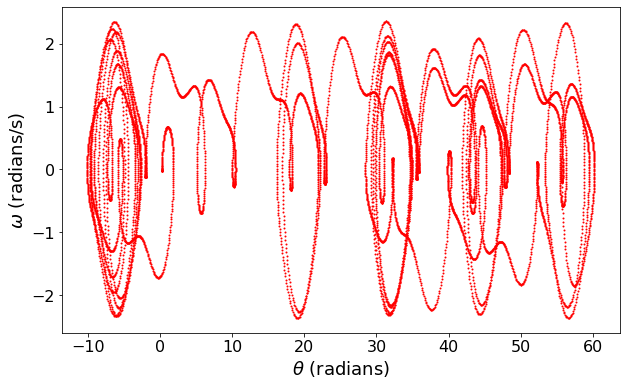

In [19]:
theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime = definePendulum(0.2, 0, 0, -9.8, 9.8, 0.5, 1.2, 2/3, 0.04, 360)
thetas_oneTwoDrive_NoRemap, omegas_oneTwoDrive_NoRemap, times_oneTwoDrive_NoRemap = RunPendulum(theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime)
LeftThreeEight, = plt.plot(thetas_oneTwoDrive_NoRemap, omegas_oneTwoDrive_NoRemap, marker = '.', markersize = 2, color = 'r', linestyle = 'None')
ylabel = plt.ylabel(r'$\omega$ (radians/s)') 
xlabel = plt.xlabel(r'$ \theta$ (radians)')
plt.savefig('RightThreeEight_noRemap.jpg', bbox_inches='tight')

### now try F$_D$ = 1.2, with remapping

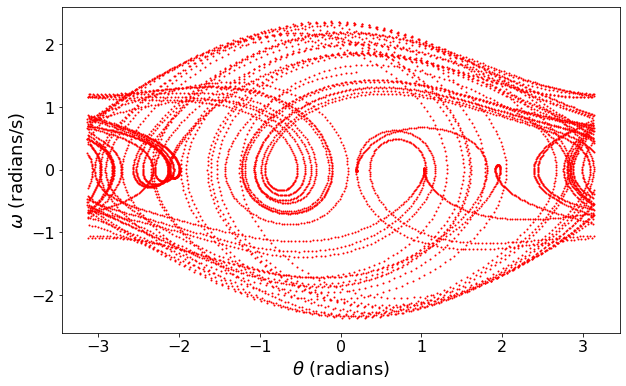

In [20]:
theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime = definePendulum(0.2, 0, 0, -9.8, 9.8, 0.5, 1.2, 2/3, 0.04, 360)
thetas_oneTwoDrive_Remap, omegas_oneTwoDrive_Remap, times_oneTwoDrive_Remap = RunPendulum(theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime, remap = True)
LeftThreeEight, = plt.plot(thetas_oneTwoDrive_Remap, omegas_oneTwoDrive_Remap, marker = '.', markersize = 2, color = 'r', linestyle = 'None')
ylabel = plt.ylabel(r'$\omega$ (radians/s)') 
xlabel = plt.xlabel(r'$ \theta$ (radians)')
plt.savefig('RightThreeEight_Remap.jpg', bbox_inches='tight')

### Now try F$_D$ = 1.465, to show we've re-entered the periodic domain (but with period quadrupuling, after ignoring transient behavior)

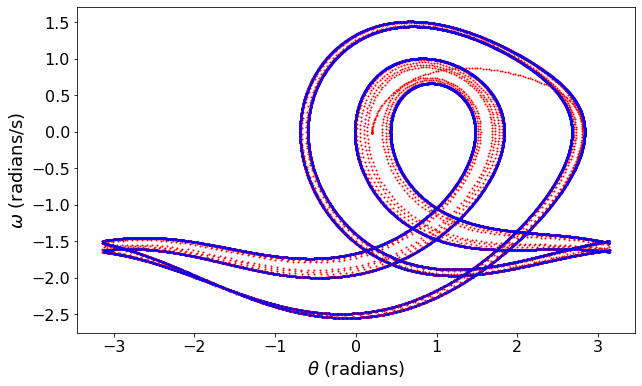

In [79]:
theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime = definePendulum(0.2, 0, 0, -9.8, 9.8, 0.5, 1.465, 2/3, 0.04, 1200)
thetas_oneTwoDrive_Remap, omegas_oneTwoDrive_Remap, times_oneTwoDrive_Remap = RunPendulum(theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime, remap = True)
LeftThreeEight, = plt.plot(thetas_oneTwoDrive_Remap, omegas_oneTwoDrive_Remap, marker = '.', markersize = 2, color = 'r', linestyle = 'None')
ohthreeseven, = plt.plot(thetas_oneTwoDrive_Remap[10000:20000], omegas_oneTwoDrive_Remap[10000:20000], marker = '.', markersize = 2, color = 'b', linestyle = 'None')
ylabel = plt.ylabel(r'$\omega$ (radians/s)') 
xlabel = plt.xlabel(r'$ \theta$ (radians)')
plt.savefig('FourSixFive_Remap.jpg', bbox_inches='tight')

### to convince ourselves, let's examine in $\theta$ vs. time space

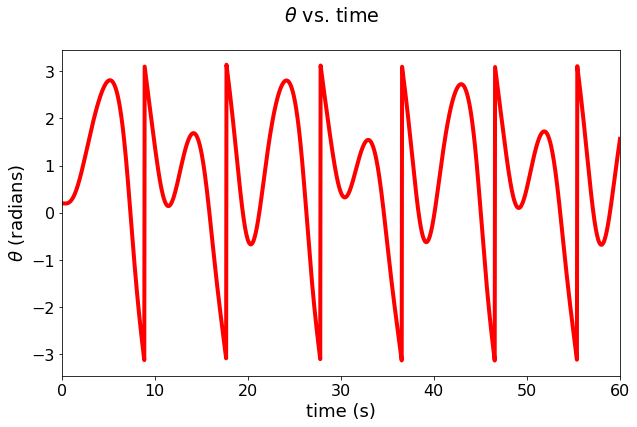

In [88]:
leftBottomThreeSix, = plt.plot(times_oneTwoDrive_Remap, thetas_oneTwoDrive_Remap, linewidth = 4, color = 'r', label = 'F$_D$=1.465')

#make plot look nice.
xlabel = plt.xlabel('time (s)') 
ylabel = plt.ylabel(r'$ \theta$ (radians)')
#ylim = plt.ylim(-100, 20)
xlim = plt.xlim(0, 60)
title = plt.suptitle(r'$\theta$ vs. time')
ytick_loc, ytick_labels = plt.yticks()
plt.savefig('OneFourSixFive.jpg', bbox_inches='tight')

# time for an interlude on logistic maps using the figures from the text!

### Now let's make a logistic map: compare $\theta_n$ to $\theta_{n+1}$ (where n = # of drive periods) for the damped, undriven case, to demonstrate that it is attracted to a fixed point

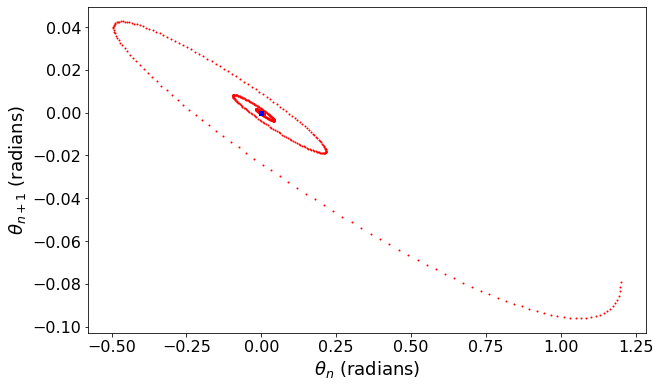

In [45]:
theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime = definePendulum(1.2, 0, 0, -9.8, 9.8, 0.5, 0, 2/3, 0.04, 360)
thetas_NoDrive, omegas_NoDrive, times_NoDrive = RunPendulum(theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime, remap = True)
thetas_StepAhead = np.interp(times_NoDrive+(math.pi*2/driveFrequency), times_NoDrive, thetas_NoDrive)    
LogisticPendulum, = plt.plot(thetas_NoDrive, thetas_StepAhead, marker = '.', markersize = 2, color = 'r', linestyle = 'None')

#overplot the last 2000 points in blue, to show that they only show up as a single blue point 
#(and thus that the pendulum is truly at rest)
LogisticPendulum, = plt.plot(thetas_NoDrive[2000:4000], thetas_StepAhead[2000:4000], marker = '.', markersize = 8, color = 'b', linestyle = 'None')

ylabel = plt.ylabel(r'$\theta_{n+1}$ (radians)') 
xlabel = plt.xlabel(r'$ \theta_n$ (radians)')
plt.savefig('LogisticPendulum_decay_noBurn.jpg', bbox_inches='tight')

### Now go back to the nice, periodic, F$_D$=0.5 case, using blue points to illustrate the non-transient behavior

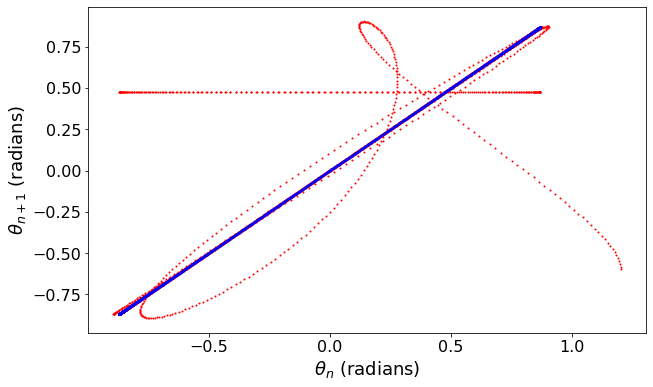

In [31]:
theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime = definePendulum(1.2, 0, 0, -9.8, 9.8, 0.5, 0.5, 2/3, 0.04, 360)
thetas_NoDrive, omegas_NoDrive, times_NoDrive = RunPendulum(theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime, remap = True)
thetas_StepAhead = np.interp(times_NoDrive+(math.pi*2/driveFrequency), times_NoDrive, thetas_NoDrive)    
LogisticPendulum, = plt.plot(thetas_NoDrive, thetas_StepAhead, marker = '.', markersize = 2, color = 'r', linestyle = 'None')
LogisticPendulum, = plt.plot(thetas_NoDrive[2000:4000], thetas_StepAhead[2000:4000], marker = '.', markersize = 2, color = 'b', linestyle = 'None')
ylabel = plt.ylabel(r'$\theta_{n+1}$ (radians)') 
xlabel = plt.xlabel(r'$ \theta_n$ (radians)')
plt.savefig('LogisticPendulum_05_noBurn.jpg', bbox_inches='tight')

### zoom in really far to demonstrate that the pendulum is nonetheless not quite on the one-one line (which is good, as it needs to be in motion!)

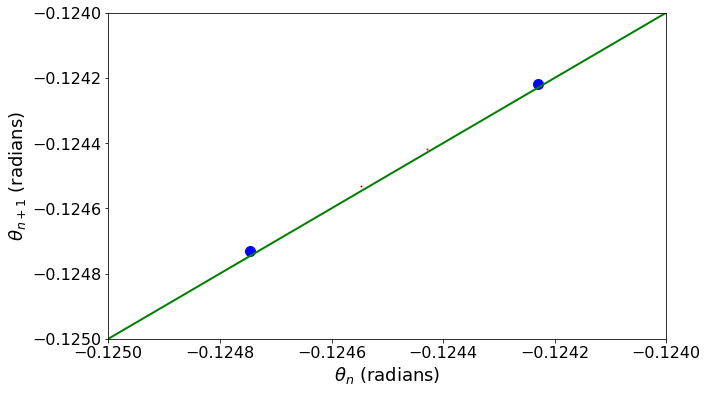

In [43]:
theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime = definePendulum(1.2, 0, 0, -9.8, 9.8, 0.5, 0.5, 2/3, 0.04, 360)
thetas_NoDrive, omegas_NoDrive, times_NoDrive = RunPendulum(theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime, remap = True)
thetas_StepAhead = np.interp(times_NoDrive+(math.pi*2/driveFrequency), times_NoDrive, thetas_NoDrive)    
LogisticPendulum, = plt.plot(thetas_NoDrive, thetas_StepAhead, marker = '.', markersize = 2, color = 'r', linestyle = 'None')
LogisticPendulum, = plt.plot(thetas_NoDrive[2000:4000], thetas_StepAhead[2000:4000], marker = '.', markersize = 20, color = 'b', linestyle = 'None')
plt.plot([-0.13,-0.12],[-0.13,-0.12], color = 'green')
ylim = plt.ylim(-0.125, -0.124)
xlim = plt.xlim(-0.125, -0.124)
ylabel = plt.ylabel(r'$\theta_{n+1}$ (radians)') 
xlabel = plt.xlabel(r'$ \theta_n$ (radians)')
plt.savefig('LogisticPendulum_05_noBurn.jpg', bbox_inches='tight')

## increase F$_D$ to 0.75

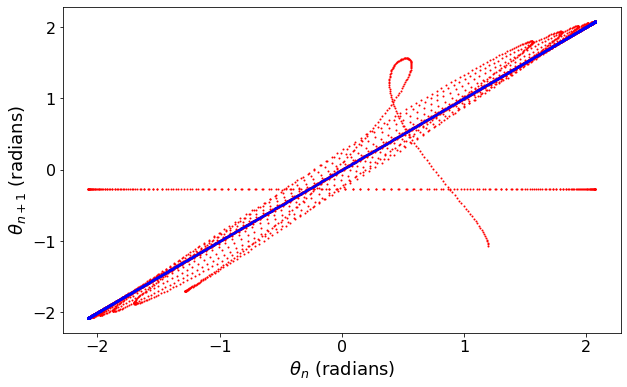

In [49]:
theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime = definePendulum(1.2, 0, 0, -9.8, 9.8, 0.5, 0.75, 2/3, 0.04, 360)
thetas_NoDrive, omegas_NoDrive, times_NoDrive = RunPendulum(theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime, remap = True)
thetas_StepAhead = np.interp(times_NoDrive+(math.pi*2/driveFrequency), times_NoDrive, thetas_NoDrive)    
LogisticPendulum, = plt.plot(thetas_NoDrive, thetas_StepAhead, marker = '.', markersize = 2, color = 'r', linestyle = 'None')
LogisticPendulum_afterBurn, = plt.plot(thetas_NoDrive[2000:4000], thetas_StepAhead[2000:4000], marker = '.', markersize = 2, color = 'b', linestyle = 'None')

ylabel = plt.ylabel(r'$\theta_{n+1}$ (radians)') 
xlabel = plt.xlabel(r'$ \theta_n$ (radians)')
#plt.legend(handles=[noDrag_ball, drag_ball], loc=1)
plt.savefig('LogisticPendulum_07_noBurn.jpg', bbox_inches='tight')

## increase F$_D$ to 1.0

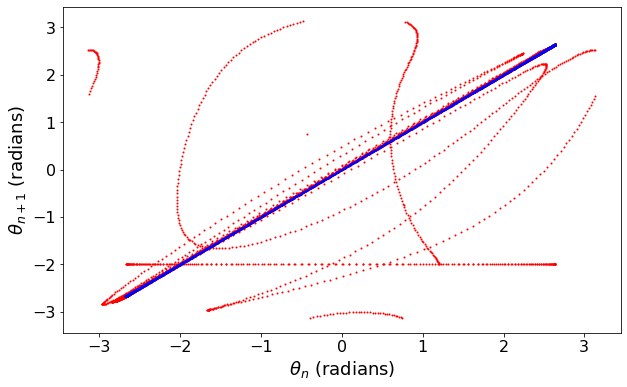

In [66]:
theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime = definePendulum(1.2, 0, 0, -9.8, 9.8, 0.5, 1.0, 2/3, 0.04, 360)
thetas_NoDrive, omegas_NoDrive, times_NoDrive = RunPendulum(theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime, remap = True)
thetas_StepAhead = np.interp(times_NoDrive+(math.pi*2/driveFrequency), times_NoDrive, thetas_NoDrive)    
LogisticPendulum, = plt.plot(thetas_NoDrive, thetas_StepAhead, marker = '.', markersize = 2, color = 'r', linestyle = 'None')
LogisticPendulum_afterBurn, = plt.plot(thetas_NoDrive[6000:8000], thetas_StepAhead[6000:8000], marker = '.', markersize = 2, color = 'b', linestyle = 'None')

ylabel = plt.ylabel(r'$\theta_{n+1}$ (radians)') 
xlabel = plt.xlabel(r'$ \theta_n$ (radians)')
plt.savefig('LogisticPendulum_1_noBurn.jpg', bbox_inches='tight')

### zoom in again to demonstrate that the non-transient behavior is off the one-to-one line

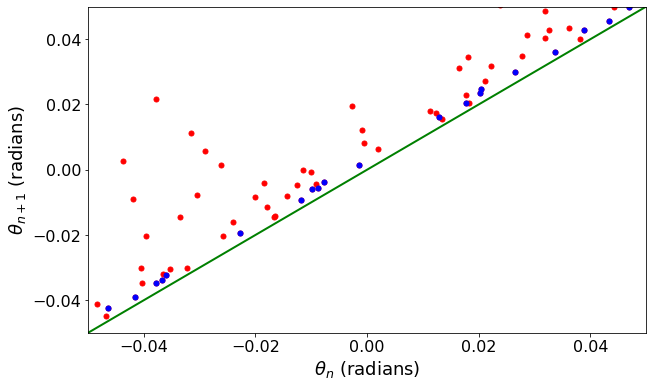

In [67]:
theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime = definePendulum(1.2, 0, 0, -9.8, 9.8, 0.5, 1.0, 2/3, 0.04, 360)
thetas_NoDrive, omegas_NoDrive, times_NoDrive = RunPendulum(theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime, remap = True)
thetas_StepAhead = np.interp(times_NoDrive+(math.pi*2/driveFrequency), times_NoDrive, thetas_NoDrive)    
LogisticPendulum, = plt.plot(thetas_NoDrive, thetas_StepAhead, marker = '.', markersize = 10, color = 'r', linestyle = 'None')
LogisticPendulum_afterBurn, = plt.plot(thetas_NoDrive[6000:8000], thetas_StepAhead[6000:8000], marker = '.', markersize = 10, color = 'b', linestyle = 'None')

plt.plot([-0.05,0.05],[-0.05,0.05], color = 'green')
ylim = plt.ylim(-0.05, 0.05)
xlim = plt.xlim(-0.05, 0.05)
ylabel = plt.ylabel(r'$\theta_{n+1}$ (radians)') 
xlabel = plt.xlabel(r'$ \theta_n$ (radians)')
plt.savefig('LogisticPendulum_1_noBurn.jpg', bbox_inches='tight')

### to convince ourselves, let's plot $\theta$ vs. $\omega$ again

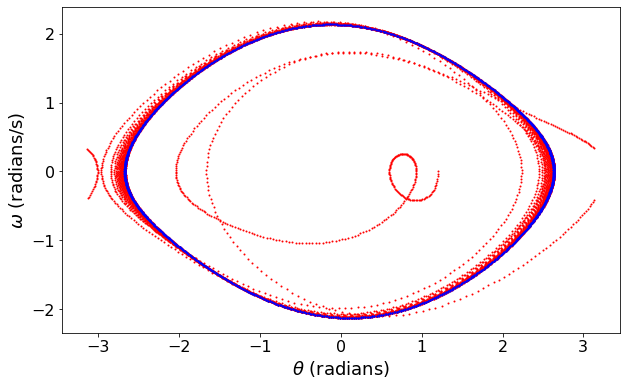

In [68]:
LeftThreeEight, = plt.plot(thetas_NoDrive, omegas_NoDrive, marker = '.', markersize = 2, color = 'r', linestyle = 'None')
ohthreeseven, = plt.plot(thetas_NoDrive[6000:8000], omegas_NoDrive[6000:8000], marker = '.', markersize = 2, color = 'b', linestyle = 'None')
ylabel = plt.ylabel(r'$\omega$ (radians/s)') 
xlabel = plt.xlabel(r'$ \theta$ (radians)')
plt.savefig('OneZero_omegatheta.jpg', bbox_inches='tight')

## Increase F$_D$ to 1.2 - yikes! Chaos!

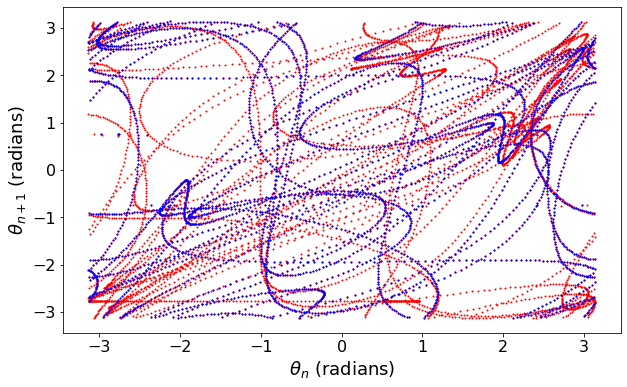

In [89]:
theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime = definePendulum(1.2, 0, 0, -9.8, 9.8, 0.5, 1.2, 2/3, 0.04, 360)
thetas_NoDrive, omegas_NoDrive, times_NoDrive = RunPendulum(theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime, remap = True)
thetas_StepAhead = np.interp(times_NoDrive+(math.pi*2/driveFrequency), times_NoDrive, thetas_NoDrive)    
LogisticPendulum, = plt.plot(thetas_NoDrive, thetas_StepAhead, marker = '.', markersize = 2, color = 'r', linestyle = 'None')
LogisticPendulum_afterBurn, = plt.plot(thetas_NoDrive[4000:8000], thetas_StepAhead[4000:8000], marker = '.', markersize = 2, color = 'b', linestyle = 'None')

ylabel = plt.ylabel(r'$\theta_{n+1}$ (radians)') 
xlabel = plt.xlabel(r'$ \theta_n$ (radians)')
plt.savefig('LogisticPendulum_12_noBurn.jpg', bbox_inches='tight')

## Increase F$_D$ to 1.4 - back to order


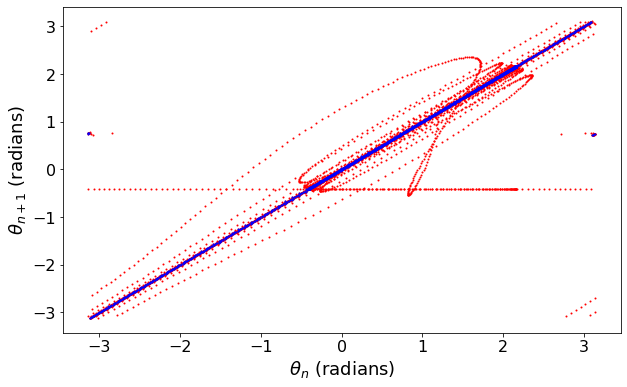

In [90]:
theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime = definePendulum(1.2, 0, 0, -9.8, 9.8, 0.5, 1.4, 2/3, 0.04, 360)
thetas_NoDrive, omegas_NoDrive, times_NoDrive = RunPendulum(theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime, remap = True)
thetas_StepAhead = np.interp(times_NoDrive+(math.pi*2/driveFrequency), times_NoDrive, thetas_NoDrive)    
LogisticPendulum, = plt.plot(thetas_NoDrive, thetas_StepAhead, marker = '.', markersize = 2, color = 'r', linestyle = 'None')
LogisticPendulum_afterBurn, = plt.plot(thetas_NoDrive[2000:4000], thetas_StepAhead[2000:4000], marker = '.', markersize = 2, color = 'b', linestyle = 'None')

ylabel = plt.ylabel(r'$\theta_{n+1}$ (radians)') 
xlabel = plt.xlabel(r'$ \theta_n$ (radians)')
plt.savefig('LogisticPendulum_14_noBurn.jpg', bbox_inches='tight')

## Increase F$_D$ to 1.44 - more complex.... but also a nice two fold symmetry....

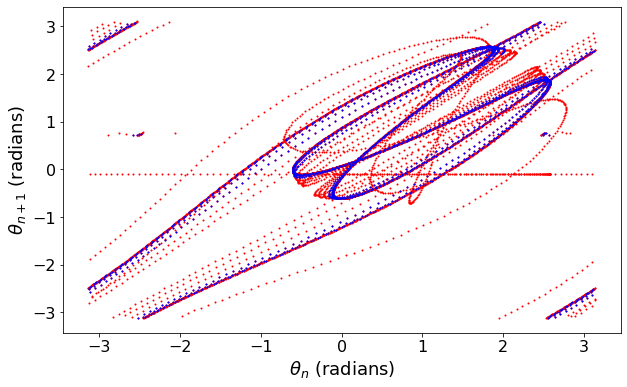

In [92]:
theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime = definePendulum(1.2, 0, 0, -9.8, 9.8, 0.5, 1.44, 2/3, 0.04, 360)
thetas_NoDrive, omegas_NoDrive, times_NoDrive = RunPendulum(theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime, remap = True)
thetas_StepAhead = np.interp(times_NoDrive+(math.pi*2/driveFrequency), times_NoDrive, thetas_NoDrive)    
LogisticPendulum, = plt.plot(thetas_NoDrive, thetas_StepAhead, marker = '.', markersize = 2, color = 'r', linestyle = 'None')
LogisticPendulum_afterBurn, = plt.plot(thetas_NoDrive[2000:4000], thetas_StepAhead[2000:4000], marker = '.', markersize = 2, color = 'b', linestyle = 'None')

ylabel = plt.ylabel(r'$\theta_{n+1}$ (radians)') 
xlabel = plt.xlabel(r'$ \theta_n$ (radians)')
plt.savefig('LogisticPendulum_144_noBurn.jpg', bbox_inches='tight')

## Now let's check our logistic map after projecting ahead to $\theta_{n+2}$ 

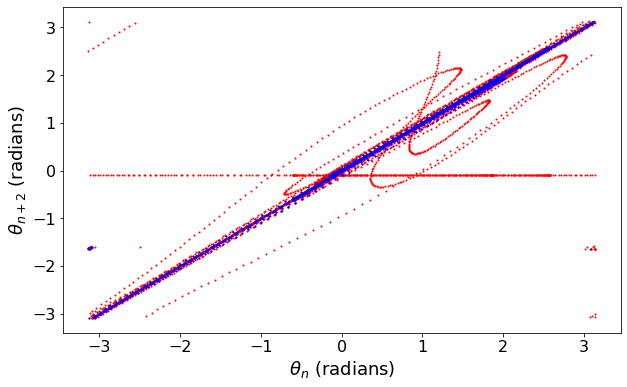

In [93]:
theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime = definePendulum(1.2, 0, 0, -9.8, 9.8, 0.5, 1.44, 2/3, 0.04, 360)
thetas_NoDrive, omegas_NoDrive, times_NoDrive = RunPendulum(theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime, remap = True)
thetas_StepAhead = np.interp(times_NoDrive+(2*math.pi*2/driveFrequency), times_NoDrive, thetas_NoDrive)    
LogisticPendulum, = plt.plot(thetas_NoDrive, thetas_StepAhead, marker = '.', markersize = 2, color = 'r', linestyle = 'None')
LogisticPendulum_afterBurn, = plt.plot(thetas_NoDrive[2000:4000], thetas_StepAhead[2000:4000], marker = '.', markersize = 2, color = 'b', linestyle = 'None')

ylabel = plt.ylabel(r'$\theta_{n+2}$ (radians)') 
xlabel = plt.xlabel(r'$ \theta_n$ (radians)')
plt.savefig('LogisticPendulum_144_n2_noBurn.jpg', bbox_inches='tight')

# back on the one-one line!!

## try F$_D$=1.465

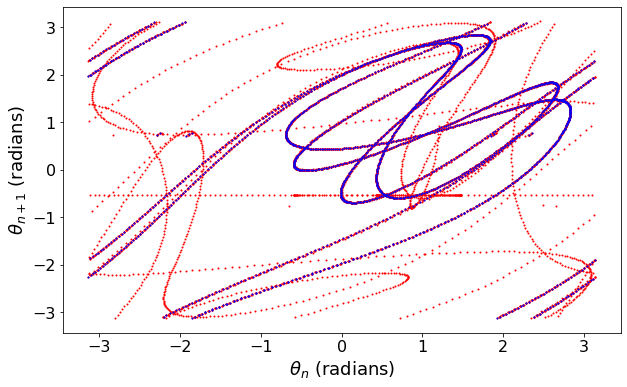

In [94]:
theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime = definePendulum(1.2, 0, 0, -9.8, 9.8, 0.5, 1.465, 2/3, 0.04, 360)
thetas_NoDrive, omegas_NoDrive, times_NoDrive = RunPendulum(theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime, remap = True)
thetas_StepAhead = np.interp(times_NoDrive+(math.pi*2/driveFrequency), times_NoDrive, thetas_NoDrive)    
LogisticPendulum, = plt.plot(thetas_NoDrive, thetas_StepAhead, marker = '.', markersize = 2, color = 'r', linestyle = 'None')
LogisticPendulum_afterBurn, = plt.plot(thetas_NoDrive[2000:4000], thetas_StepAhead[2000:4000], marker = '.', markersize = 2, color = 'b', linestyle = 'None')

ylabel = plt.ylabel(r'$\theta_{n+1}$ (radians)') 
xlabel = plt.xlabel(r'$ \theta_n$ (radians)')
plt.savefig('LogisticPendulum_1465_n1_noBurn.jpg', bbox_inches='tight')

### looks symmetric, though complex... try increasing n+ factors to see how logistic map evolves

### n+2...

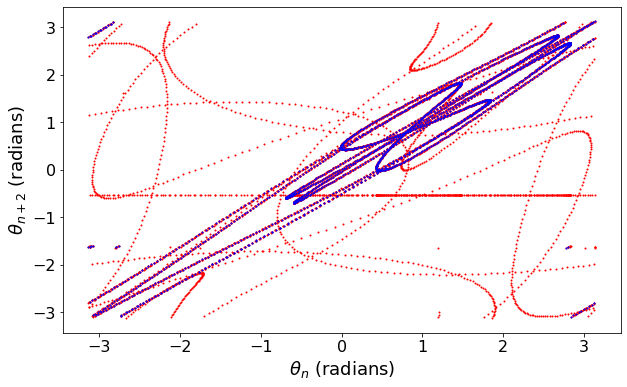

In [95]:
theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime = definePendulum(1.2, 0, 0, -9.8, 9.8, 0.5, 1.465, 2/3, 0.04, 360)
thetas_NoDrive, omegas_NoDrive, times_NoDrive = RunPendulum(theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime, remap = True)
thetas_StepAhead = np.interp(times_NoDrive+(2*math.pi*2/driveFrequency), times_NoDrive, thetas_NoDrive)    
LogisticPendulum, = plt.plot(thetas_NoDrive, thetas_StepAhead, marker = '.', markersize = 2, color = 'r', linestyle = 'None')
LogisticPendulum_afterBurn, = plt.plot(thetas_NoDrive[2000:4000], thetas_StepAhead[2000:4000], marker = '.', markersize = 2, color = 'b', linestyle = 'None')

ylabel = plt.ylabel(r'$\theta_{n+2}$ (radians)') 
xlabel = plt.xlabel(r'$ \theta_n$ (radians)')
plt.savefig('LogisticPendulum_1465_n2_noBurn.jpg', bbox_inches='tight')

### n+3....

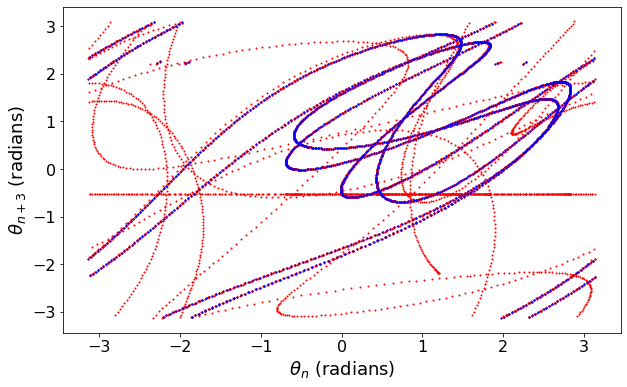

In [96]:
theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime = definePendulum(1.2, 0, 0, -9.8, 9.8, 0.5, 1.465, 2/3, 0.04, 360)
thetas_NoDrive, omegas_NoDrive, times_NoDrive = RunPendulum(theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime, remap = True)
thetas_StepAhead = np.interp(times_NoDrive+(3*math.pi*2/driveFrequency), times_NoDrive, thetas_NoDrive)    
LogisticPendulum, = plt.plot(thetas_NoDrive, thetas_StepAhead, marker = '.', markersize = 2, color = 'r', linestyle = 'None')
LogisticPendulum_afterBurn, = plt.plot(thetas_NoDrive[2000:4000], thetas_StepAhead[2000:4000], marker = '.', markersize = 2, color = 'b', linestyle = 'None')

ylabel = plt.ylabel(r'$\theta_{n+3}$ (radians)') 
xlabel = plt.xlabel(r'$ \theta_n$ (radians)')
plt.savefig('LogisticPendulum_1465_n3_noBurn.jpg', bbox_inches='tight')

### n+4 ... back to the one-one line!

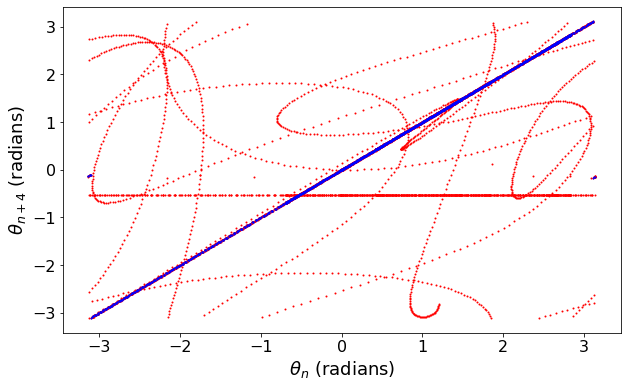

In [97]:
theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime = definePendulum(1.2, 0, 0, -9.8, 9.8, 0.5, 1.465, 2/3, 0.04, 360)
thetas_NoDrive, omegas_NoDrive, times_NoDrive = RunPendulum(theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime, remap = True)
thetas_StepAhead = np.interp(times_NoDrive+(4*math.pi*2/driveFrequency), times_NoDrive, thetas_NoDrive)    
LogisticPendulum, = plt.plot(thetas_NoDrive, thetas_StepAhead, marker = '.', markersize = 2, color = 'r', linestyle = 'None')
LogisticPendulum_afterBurn, = plt.plot(thetas_NoDrive[2000:4000], thetas_StepAhead[2000:4000], marker = '.', markersize = 2, color = 'b', linestyle = 'None')

ylabel = plt.ylabel(r'$\theta_{n+4}$ (radians)') 
xlabel = plt.xlabel(r'$ \theta_n$ (radians)')
plt.savefig('LogisticPendulum_1465_n4_noBurn.jpg', bbox_inches='tight')

### finally, let's go back to that chaotic F$_D$=1.2 case, and look at the $\omega$ vs. $\theta$ attractor

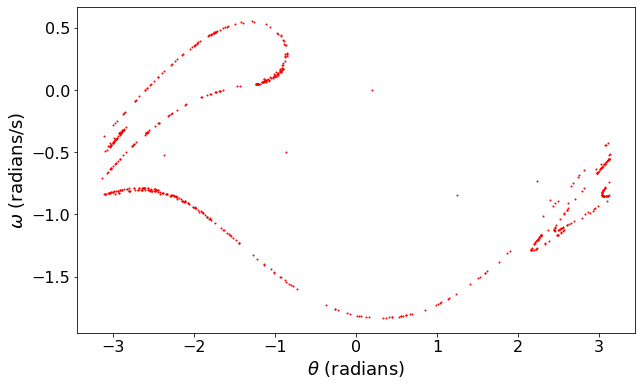

In [98]:
theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime = definePendulum(0.2, 0, 0, -9.8, 9.8, 0.5, 1.2, 2/3, 0.04, 6000)
skipPeriods = 0
periodic_thetas, periodic_omegas = MakePoincare(theta_0, omega_0, time_0, g, l, q, driveForce, driveFrequency, RK2timeStep, FullTime, skipPeriods, remap = True)
LeftThreeEight, = plt.plot(periodic_thetas, periodic_omegas, marker = '.', markersize = 2, color = 'r', linestyle = 'None')
ylabel = plt.ylabel(r'$\omega$ (radians/s)') 
xlabel = plt.xlabel(r'$ \theta$ (radians)')
plt.savefig('ThreeNine.jpg', bbox_inches='tight')